# Model Explicit Likelihood Inference
Infer from a cosmological model via MCMC samplers. 

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.5' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, grad, debug, lax, flatten_util
from jax.tree_util import tree_map

import numpyro
from numpyro.handlers import seed, condition, trace
from functools import partial
from getdist import plots

%matplotlib inline
%load_ext autoreload 
%autoreload 2

import mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
mlflow.set_experiment("ELI")
from montecosmo.utils import pickle_dump, pickle_load, get_vlim, theme_switch, sample_and_save, load_runs
save_dir = os.path.expanduser("~/scratch/pickles/")

2024-05-05 19:58:37.747465: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [36]:
# !jupyter nbconvert --to script ./src/montecosmo/tests/model_ELI.ipynb

/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


[NbConvertApp] Converting notebook ./src/montecosmo/tests/model_ELI.ipynb to script
[NbConvertApp] Writing 16852 bytes to src/montecosmo/tests/model_ELI.py


## Inference

### Import

In [3]:
from montecosmo.models import pmrsd_model, prior_model, get_logp_fn, get_score_fn, get_simulator, get_pk_fn, get_param_fn
from montecosmo.models import print_config, get_prior_mean, default_config as config

# Build and render model
# config.update(a_lpt=0.5, mesh_size=64*np.ones(3, dtype=int))
model = partial(pmrsd_model, **config)
print_config(model)

# # Get fiducial parameters
# param_fn = get_param_fn(**config)
# fiduc_model = condition(partial(model, trace_reparam=True), param_fn(inverse=True, **get_prior_mean(model)))
# fiduc_params = get_simulator(fiduc_model)(rng_seed=0)

# # # Chain init
# @jit
# @vmap
# def sample_init_chains(rng_key, scale_std):
#     params_ = seed(prior_model, rng_key)(**config)
#     init_params = get_param_fn(scale_std=scale_std, **config)(**params_)
#     return get_param_fn(**config)(inverse=True, **init_params)

# init_params_ = sample_init_chains(jr.split(jr.key(1), 7), jnp.array([0]+6*[1/10]))
# init_params_ = tree_map(lambda x,y: jnp.concatenate((jnp.array(x)[None], y), axis=0), 
#                         get_param_fn(**config)(inverse=True, **fiduc_params), init_params_)
# pickle_dump(fiduc_params, save_dir+"fiduc_params2.p")
# pickle_dump(init_params_, save_dir+"init_params_2.p")

# Load fiducial and chain init params
fiduc_params = pickle_load(save_dir+"fiduc_params.p")
init_params_ = pickle_load(save_dir+"init_params_.p")

# Condition model on observables
obs_names = ['obs_mesh']
obs_params = {name: fiduc_params[name] for name in obs_names}
obs_model = condition(model, obs_params)
logp_fn = get_logp_fn(obs_model)
# print(fiduc_params, init_params_)

# CONFIG
{'mesh_size': array([64, 64, 64]), 'box_size': array([640., 640., 640.]), 'a_lpt': 0.5, 'a_obs': 0.5, 'galaxy_density': 0.001, 'trace_reparam': False, 'trace_meshes': False, 'prior_config': {'Omega_m': ['{\\Omega}_m', 0.3111, 0.2], 'sigma8': ['{\\sigma}_8', 0.8102, 0.2], 'b1': ['{b}_1', 1.0, 0.5], 'b2': ['{b}_2', 0.0, 2.0], 'bs2': ['{b}_{s^2}', 0.0, 2.0], 'bn2': ['{b}_{\\nabla^2}', 0.0, 2.0]}, 'lik_config': {'obs_std': 1.0}}

# INFOS
cell_size:        [10.0, 10.0, 10.0] Mpc/h
delta_k:          0.00982 h/Mpc
k_nyquist:        0.31416 h/Mpc
mean_gxy_density: 1.000 gxy/cell



In [4]:
print(fiduc_params.keys(), '\n', init_params_['Omega_m_'], '\n', init_params_['init_mesh_'][:,0,0,0])

dict_keys(['Omega_m_', 'sigma8_', 'b1_', 'b2_', 'bs2_', 'bn2_', 'init_mesh_', 'Omega_m', 'sigma8', 'init_mesh', 'b1', 'b2', 'bs2', 'bn2', 'obs_mesh']) 
 [-0.0796027  -0.07960285  0.04843828 -0.21266134  0.05903318 -0.31464675
 -0.04204855 -0.06571629] 
 [ 0.913383    0.          0.0867136   0.09719938  0.23013133 -0.13022844
 -0.06570464  0.16659732]


### Run

In [8]:
num_samples, max_tree_depth, n_runs, num_chains = 256, 10, 20, 8
# num_samples, max_tree_depth, n_runs, num_chains = 128, 10, 10, 4
# num_samples, max_tree_depth, n_runs, num_chains = 128, 10, 5, 4
# num_samples, max_tree_depth, n_runs, num_chains = 64, 10, 4, 8

# Variables to save
extra_fields = ['num_steps'] # e.g. 'num_steps'
# save_path = save_dir + f"HMC_ns{num_samples:d}_x_nc{num_chains}"
# save_path = save_dir + f"NUTS_ns{num_samples:d}_x_nc{num_chains}"
# save_path = save_dir + f"HMC_ns{num_samples:d}_test9"
# save_path = save_dir + f"NUTS_ns{num_samples:d}"

nuts_kernel = numpyro.infer.NUTS(
    model=obs_model,
    # init_strategy=numpyro.infer.init_to_value(values=fiduc_params)
    # inverse_mass_matrix=variance_as_invM, 
    adapt_mass_matrix=True,
    # dense_mass=[('Omega_c_base', 'sigma8_base')], # XXX: dense matrix for cosmo params joint, diagonal for the rest
    step_size=1e-6, 
    adapt_step_size=True,
    max_tree_depth=max_tree_depth,)

hmc_kernel = numpyro.infer.HMC(
    model=obs_model,
    # init_strategy=numpyro.infer.init_to_value(values=fiduc_params),
    adapt_mass_matrix=True,
    step_size=1e-3, 
    adapt_step_size=True,
    # num_steps=1,
    trajectory_length= 1e-3 * 1023, # (2**max_tree_depth-1)*step_size_NUTS/4, compare with default 2pi.
    )

# # Propose MALA step size based on [Chen+2019](http://arxiv.org/abs/1801.02309)
# L_smoothness, m_strong_convex = 1, 1 # log density regularity properties
# condition_number = L_smoothness / m_strong_convex
# print(f"MALA step size proposal={1 / (L_smoothness * (config['mesh_size'].prod() * condition_number)**0.5):e}")

# from numpyro.contrib.tfp.mcmc import MetropolisAdjustedLangevinAlgorithm as MALA
# mala_kernel = MALA(model=obs_model,
#                     init_strategy=numpyro.infer.init_to_value(values=fiduc_params),
#                     step_size=0.001,)

mcmc = numpyro.infer.MCMC(
    sampler=hmc_kernel,
    num_warmup=num_samples,
    num_samples=num_samples, # for each run
    num_chains=num_chains,
    chain_method="vectorized",
    progress_bar=True,)

# last_state = pickle_load(save_dir+"NUTS_ns60_mtd10_laststate16.p")
# mcmc.post_warmup_state = last_state

In [6]:
# mlflow.end_run()
# mlflow.start_run(run_name="HMC, ss=1e-3, L=1, 1initcond")
# mlflow.log_params(config)
# mlflow.log_params({'n_runs':n_runs, 'num_samples':num_samples, 'max_tree_depth':max_tree_depth, 'num_chains':num_chains})
print({'n_runs':n_runs, 'num_samples':num_samples, 'max_tree_depth':max_tree_depth, 'num_chains':num_chains})
print(save_path)

In [7]:
init_params_one_ = tree_map(lambda x: x[1], init_params_)
# mlflow.log_metric('halt',0) # 31.46s/it 4chains, 37.59s/it 8chains
mcmc_runned = sample_and_save(mcmc, n_runs, save_path, extra_fields=extra_fields, init_params=init_params_one_)
# mcmc_runned = sample_and_save(mcmc, n_runs, save_path, extra_fields=extra_fields, init_params=init_params_)
# mlflow.log_metric('halt',1)

run 0/5 (warmup)


In [37]:
laststate = pickle_load(save_path+'_laststate.p')
laststate.mean_accept_prob, laststate.adapt_state.step_size

(Array([0.8108881 , 0.823729  , 0.7760806 , 0.7803052 , 0.81214803,
        0.7888646 , 0.8068306 , 0.8407685 ], dtype=float32),
 Array([0.0030548 , 0.00288497, 0.00339197, 0.0034201 , 0.00303051,
        0.00328963, 0.00309079, 0.00266182], dtype=float32))

In [ ]:
mclmc = blackjax.mcmc.mclmc.mclmc(
    logdensity_fn=logdensity_fn,
    L=L,
    step_size=step_size
)
state = mclmc.init(position)
new_state, info = mclmc.step(rng_key, state)

## Analysis

In [12]:
start_run, end_run = 0,16
var_names = [name+'_' for name in config['prior_config']] + ['num_steps']
# var_names = None

# post_samples_ = load_runs(save_path, start_run, end_run, var_names, conc_axis=[1,0], verbose=True)
post_samples_ = load_runs(save_path, start_run, end_run, var_names, conc_axis=[1], verbose=True)
# mlflow.log_params({'n_samples':n_samples, 'n_evals':n_evals})
# post_samples = [param_vfn(**s) for s in post_samples_]
post_samples = get_param_fn(**config)(**post_samples_)

loading: NUTS_ns256_x_nc8
total n_samples: (8, 4352), total n_evals: [4448651 4447518 4449156 4447872 4447922 4448260 4448905 4448779]


### Chain

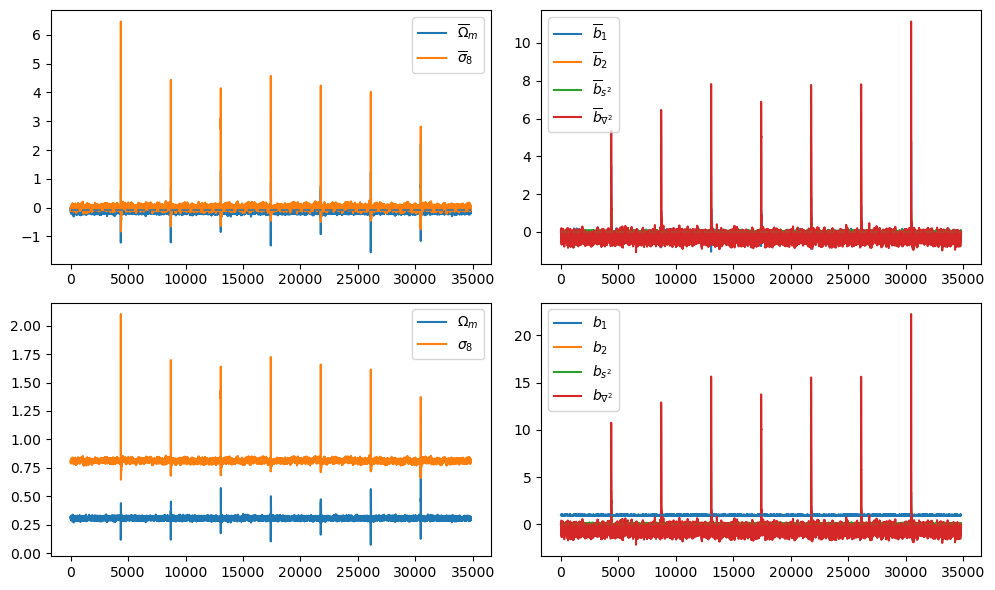

In [10]:
%matplotlib inline
def plot_chain(samples:dict, prior_config:dict, fiduc:dict, **config):
    labels = []
    for name in samples:
        if name.endswith('_'): # convention for a latent value 
            lab = "\\overline"+prior_config[name[:-1]][0]
        else:
            lab = prior_config[name][0]
        labels.append('$'+lab+'$')

    samples_arr = np.array(list((samples.values()))).T

    plt.plot(samples_arr, label=labels)
    plt.hlines([fiduc[name] for name in samples], 
            xmin=0, xmax=len(samples_arr), 
            ls="--", alpha=0.75,
            color=[f"C{i}" for i in range(len(samples))],)
# slice_toplot = np.concatenate([range(i,i+10) for i in [0,5*60-5, 6*60-5]])

plot_fn = partial(plot_chain, fiduc=fiduc_params, **config)
plt.figure(figsize=(10,6))
plt.subplot(221)
plot_fn({name:post_samples_[name] for name in ['Omega_m_','sigma8_']})
plt.legend(), 
plt.subplot(222)
plot_fn({name:post_samples_[name] for name in ['b1_','b2_','bs2_','bn2_']})
plt.legend(), 
plt.subplot(223)
plot_fn({name:post_samples[name] for name in ['Omega_m','sigma8']})
plt.legend(), 
plt.subplot(224)
plot_fn({name:post_samples[name] for name in ['b1', 'b2','bs2','bn2']})
plt.legend(), 
plt.tight_layout()
# mlflow.log_figure(plt.gcf(), f"NUTS_chain_L1_1o10init_neval836666.svg")
plt.show();

### Contours

In [27]:
from numpyro.diagnostics import effective_sample_size, gelman_rubin

def get_metric_traj(metric_fn, samples, num, num_steps=None):
    def _get_metric_traj(samples):
        metrics = []
        length = len(samples[0])
        for i_filt in np.arange(length, 1, -length// num)[::-1]:

            if num_steps is not None:
                metrics.append([num_steps[:,:i_filt].sum(), metric_fn(samples[:,:i_filt])])
            else:
                metrics.append(metric_fn(samples[:,:i_filt]))
        return jnp.array(metrics).T
    return tree_map(_get_metric_traj, samples)

n_toplot = 300
ESSs = get_metric_traj(effective_sample_size, post_samples, n_toplot, post_samples_['num_steps'])
GRs = get_metric_traj(gelman_rubin, post_samples, n_toplot, post_samples_['num_steps'])

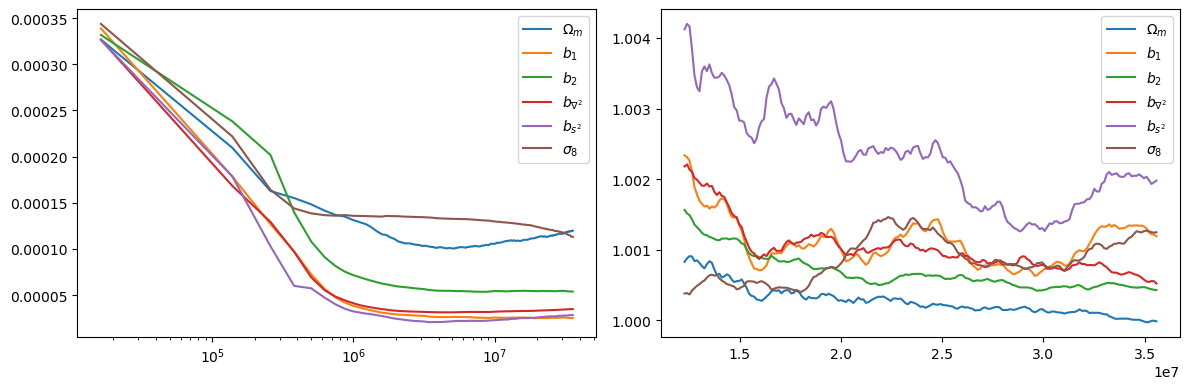

In [35]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plot_fn = lambda x, **kwargs: plt.semilogx(x[0], x[1]/x[0], **kwargs)
for name, val in ESSs.items():
    plot_fn(val, label='$'+config['prior_config'][name][0]+'$')
plt.legend()

plt.subplot(122)
plot_fn = lambda x, **kwargs: plt.plot(*x, **kwargs)
for name, val in GRs.items():
    plot_fn(val[:,100:], label='$'+config['prior_config'][name][0]+'$')
plt.legend()
plt.tight_layout()
plt.show();

In [31]:
from numpyro.diagnostics import print_summary
print_summary(post_samples, group_by_chain=True) # NOTE: group_by_chain if several chains


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.31      0.01      0.30      0.29      0.32   4259.60      1.00
    sigma8      0.81      0.03      0.81      0.79      0.83   4020.12      1.00
        b1      0.98      0.06      0.98      0.92      1.03    888.48      1.01
        b2     -0.03      0.05     -0.03     -0.06     -0.01   1913.34      1.00
       bs2      0.02      0.07      0.02     -0.07      0.11   1010.20      1.01
       bn2     -0.56      0.74     -0.60     -1.20      0.01   1238.17      1.00



In [ ]:
paths = ["NUTS_ns4429_mtd3","NUTS_ns243_mtd8","NUTS_ns60_mtd10","NUTS_ns15_mtd12"]
legend_labels = ["NUTS, mtd=3", "NUTS, mtd=8","NUTS, mtd=10","NUTS, mtd=12"]
start_run, end_run = [1,1,1,1], [10,5,5,5]

load_paths = np.array([os.path.join(save_dir, path) for path in paths])
var_names = [name+'_' for name in config['prior_config']]

post_samples_ = load_runs(load_paths, start_run, end_run, var_names, verbose=True)
post_samples = [param_fn(**s) for s in post_samples_]

loading: NUTS_ns4429_mtd3
total run length: 44290
loading: NUTS_ns243_mtd8
total run length: 1215
loading: NUTS_ns60_mtd10
total run length: 300
loading: NUTS_ns15_mtd12
total run length: 75


<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3213162/1211131261.py:5: SyntaxWarning: invalid escape sequence '\s'
  gd1 = gdsamples.copy(label="NUTS, mtd=10, 1$\sigma$-smooth", settings={'smooth_scale_2D':1,'smooth_scale_1D':1,})


Removed no burn in
# NUTS, mtd=10
using 10240 rows, 6 parameters; mean weight 1.0, tot weight 10240.0
Equiv number of single samples (sum w)/max(w): 10240
Effective number of weighted samples (sum w)^2/sum(w^2): 10240


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.31      0.01      0.31      0.29      0.32   1492.85      1.00
        b1      0.98      0.03      0.98      0.92      1.03    235.19      1.00
        b2     -0.03      0.01     -0.03     -0.06     -0.01    429.92      1.00
       bn2     -0.59      0.36     -0.60     -1.19      0.00    630.28      1.00
       bs2      0.02      0.05      0.02     -0.07      0.10    392.31      1.00
    sigma8      0.81      0.01      0.81      0.79      0.83    293.11      1.00



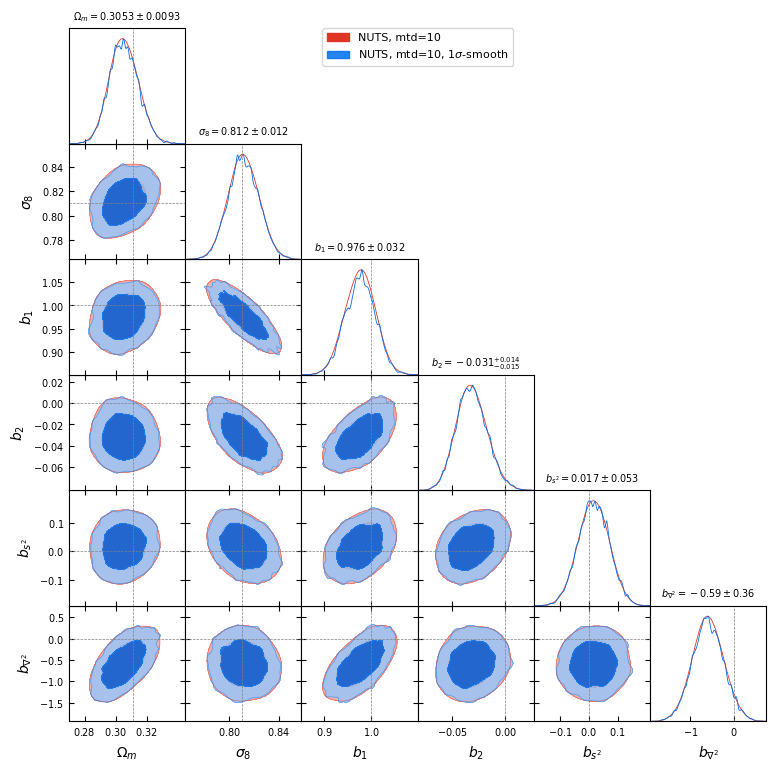

In [16]:
%matplotlib inline
from montecosmo.utils import get_gdsamples, get_gdprior

gdsamples = get_gdsamples(post_samples, label="NUTS, mtd=10", verbose=True, **config)
gd1 = gdsamples.copy(label="NUTS, mtd=10, 1$\sigma$-smooth", settings={'smooth_scale_2D':1,'smooth_scale_1D':1,})

# gdsamples.append(get_gdprior(post_samples, verbose=True, **config))
g = plots.get_subplot_plotter(width_inch=9)
# g.settings.solid_colors='tab10_r's
g.triangle_plot(roots=[gdsamples, gd1] , 
                title_limit=1, 
                filled=True, 
                # param_limits={n:[m-2*s,m+2*s] for n,m,s in zip(names, mean, std)},
                markers=fiduc_params,
                )
# mlflow.log_figure(plt.gcf(), f"NUTS_contour_mtd3-8-10-12.svg", save_kwargs={'bbox_inches':'tight'}) # NOTE: tight bbox better
# plt.savefig('NUTS_mtd10_8192_unstandard_short.svg', bbox_inches='tight')
plt.show();

Removed no burn in
Removed no burn in
Removed no burn in


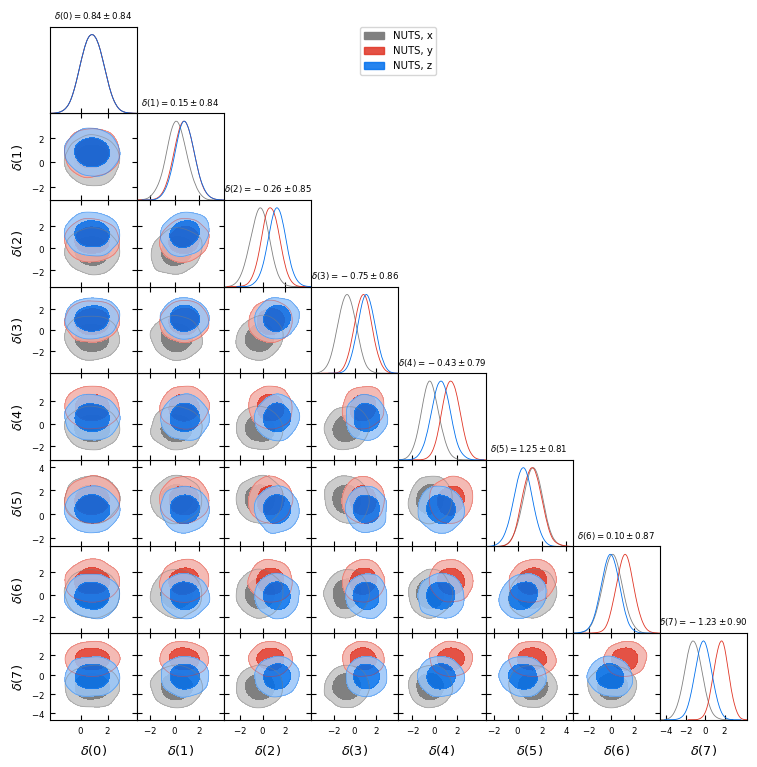

In [8]:
from getdist import MCSamples

def get_gdsamples_mesh(samples:dict, fiduc:dict, n:int, stop:int=None, axis:int=0, label:str=None):
    mesh_samples = samples['init_mesh']
    mesh_fiduc = fiduc['init_mesh']

    subsamples = {}
    subfiduc = {}
    labels = []
    slices0 = len(mesh_fiduc.shape)*[slice(0,1)]
    name0 = len(mesh_fiduc.shape) * ["0"]
    if stop is None:
        stop = mesh_fiduc.shape[axis]
    for i in np.linspace(0, stop, n, endpoint=False, dtype=int):
        slices, name = slices0.copy(), name0.copy()
        slices[axis] = slice(i,i+1)
        # name[axis] = str(i)
        # name = "delta("+",".join(name)+")"
        # lab = "\\"+name
        name = f"delta({i})"
        lab = "\\"+name

        subsamples[name] = mesh_samples[:,*slices].squeeze()
        subfiduc[name] = mesh_fiduc[*slices].squeeze()
        labels.append(lab)
 
    gdsamples = MCSamples(samples=list(subsamples.values()), names=list(subsamples.keys()), labels=labels, label=label)
    return gdsamples, subfiduc

ntoplot = 8
stop = 8
gdsamplesX, subfiduc = get_gdsamples_mesh(post_samples, fiduc_params, ntoplot, stop, axis=0, label="NUTS, x")
gdsamplesY, subfiduc = get_gdsamples_mesh(post_samples, fiduc_params, ntoplot, stop, axis=1, label="NUTS, y")
gdsamplesZ, subfiduc = get_gdsamples_mesh(post_samples, fiduc_params, ntoplot, stop, axis=2, label="NUTS, z")

g.triangle_plot(roots=[gdsamplesX, gdsamplesY, gdsamplesZ] , 
                title_limit=1, 
                filled=True, 
                # markers=subfiduc,
                )
# plt.savefig('NUTS_mtd10_1560_meshtriangle.svg', dpi=200, bbox_inches='tight')
plt.show();

### Spectrum distribution

In [9]:
from jaxpm.painting import cic_paint, cic_read, compensate_cic
pk_fiduc = pk_fn(fiduc_params['init_mesh'])
pk_post = vmap(pk_fn)(post_samples['init_mesh'])
qs = jnp.array([0.0015, 0.0250, 0.1600, 0.5, 0.840, 0.9750, 0.9985])
pk_0015, pk_0250, pk_1600, pk_5000, pk_8400, pk_9750, pk_9985 = jnp.quantile(pk_post, q=qs, axis=0)

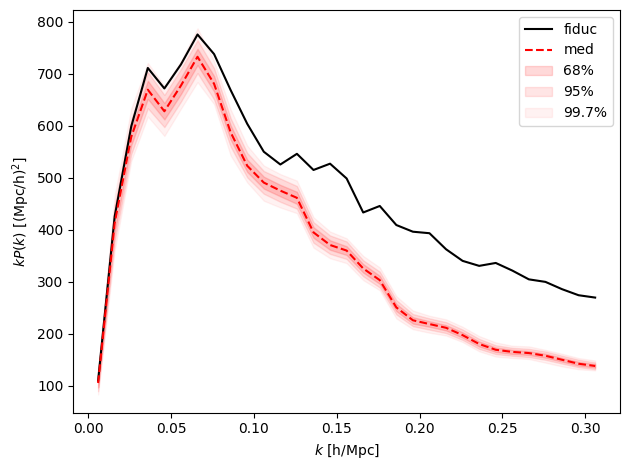

In [10]:
plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[1], *args, **kwargs)
plotfill_fn = lambda pklow, pkup, *args, **kwargs: plt.fill_between(pklow[0], pklow[0]*pklow[1], pklow[0]*pkup[1], *args, **kwargs)

plot_fn(pk_fiduc, 'k', label='fiduc')
plot_fn(pk_5000, 'r--', label='med')
plotfill_fn(pk_1600, pk_8400, alpha=0.15, color='red', label='68%')
plotfill_fn(pk_0250, pk_9750, alpha=0.10, color='red', label='95%')
plotfill_fn(pk_0015, pk_9985, alpha=0.05, color='red', label='99.7%')
plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$k P(k)$ [(Mpc/h)$^2$]")
plt.legend()
plt.tight_layout()
# plt.savefig('post_pk.svg', dpi=200, bbox_inches='tight')
plt.show()

### Mass matrix

In [132]:
# Load mass matrix
import pickle
with open(save_path+f"_laststate16.p", 'rb') as file:
    last_state = pickle.load(file)
    
inverse_mass_matrix = last_state.adapt_state.inverse_mass_matrix
print(last_state.adapt_state.step_size, inverse_mass_matrix)
# np.cov(np.array([post_samples[var_name] for var_name in ['Omega_c_base', 'sigma8_base']]))

0.0036300123 {('Omega_c_', 'b1_', 'b2_', 'bnl_', 'bs_', 'init_mesh_', 'sigma8_'): Array([6.1043068e-03, 1.6954450e-03, 7.9886860e-04, ..., 8.5615098e-01,
       6.2965083e-01, 3.9922595e-03], dtype=float32)}


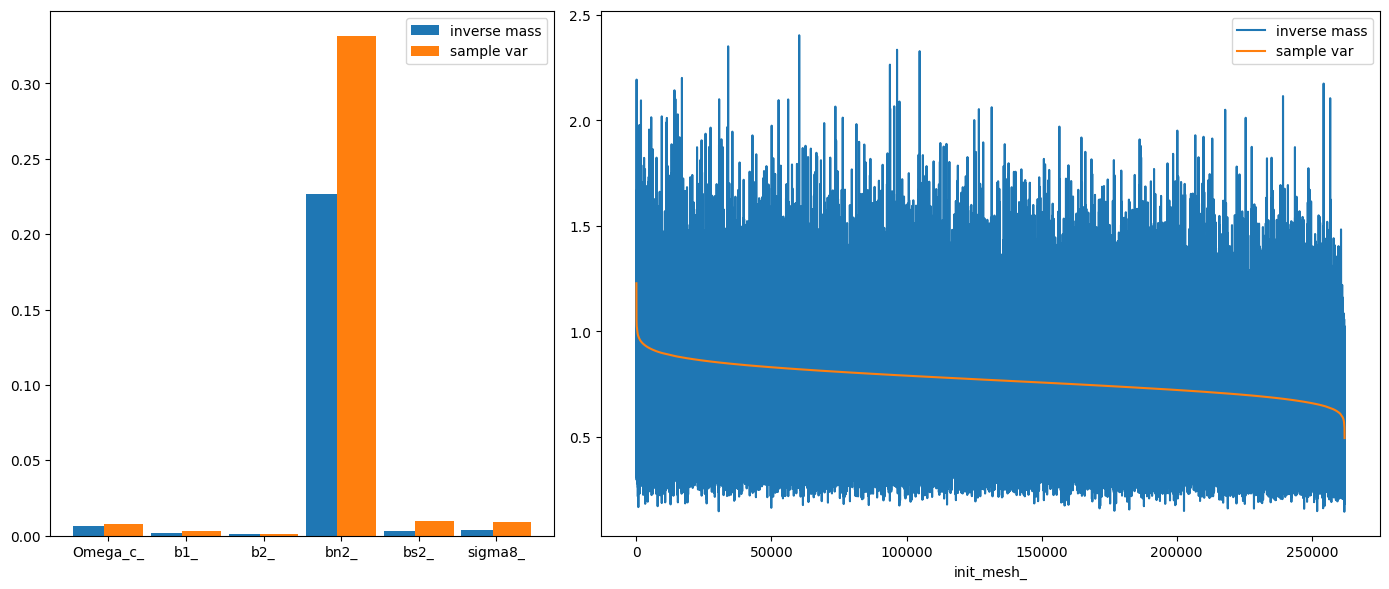

In [143]:
# Plot inverse mass matrix vs. posterior sample variance
invM_arr = np.array(list(inverse_mass_matrix.values()))[0] # also jax.tree_util.tree_flatten(inverse_mass_matrix)[0][0]
var_names = list(inverse_mass_matrix.keys())[0]

post_variance_mesh, post_variance_cosmo = [], []
invM_mesh, invM_cosmo, invM_cosmo_name = [], [], []
invM_head = 0
for var_name in var_names:
    if var_name == 'bnl_':
        var_name = 'bn2_'
    if var_name == 'bs_':
        var_name = 'bs2_'
    var_variance = post_samples_[var_name].var(axis=0).flatten()
    new_invM_head = invM_head + len(var_variance)
    if var_name in ['init_mesh_']:
        post_variance_mesh = np.concatenate((post_variance_mesh, var_variance))
        invM_mesh = np.concatenate((invM_mesh, invM_arr[invM_head: new_invM_head]))
    else:
        post_variance_cosmo = np.concatenate((post_variance_cosmo, var_variance))
        invM_cosmo = np.concatenate((invM_cosmo, invM_arr[invM_head: new_invM_head]))
        invM_cosmo_name += [var_name]
    invM_head = new_invM_head


plt.figure(figsize=(14,6))
plt.subplot(1,5,(1,2))
x_pos = np.arange(len(invM_cosmo))
plt.bar(x_pos, invM_cosmo, width=.5, label="inverse mass")
plt.bar(x_pos+.4, post_variance_cosmo, width=.5, label="sample var")
plt.xticks(x_pos+.2, invM_cosmo_name)
plt.legend()

plt.subplot(1,5,(3,5))
# argsort_invM_mesh = np.argsort(invM_mesh) 
# plt.plot(invM_mesh[argsort_invM_mesh][::-1], label="inverse mass")
# plt.plot(post_variance_mesh[argsort_invM_mesh][::-1], label="sample var")
argsort_postvar_mesh = np.argsort(post_variance_mesh) 
plt.plot(invM_mesh[argsort_postvar_mesh][::-1], label="inverse mass")
plt.plot(post_variance_mesh[argsort_postvar_mesh][::-1], label="sample var")
plt.xlabel("init_mesh_")
plt.legend(), plt.tight_layout()
plt.savefig(save_path+"_invMvar.svg");

In [ ]:
# # Save posterior variance as inverse mass matrix format
# post_variance = []
# for var_name in var_names:
#     if var_name == 'init_mesh_base':
#         var_name = 'init_mesh'
#         post_variance = np.concatenate((post_variance, np.ones(post_samples[var_name][0].flatten().shape)))
#     else:
#         post_variance = np.concatenate((post_variance, post_samples[var_name].var(axis=0).flatten()))
#         post_variance = np.concatenate((post_variance, ))
# variance_as_invM = {var_names: post_variance}
# print(variance_as_invM)

# with open(save_path+f"_invM.p", 'wb') as file:
#     pickle.dump(post_variance, file, protocol=pickle.HIGHEST_PROTOCOL)

### Init. cond. 

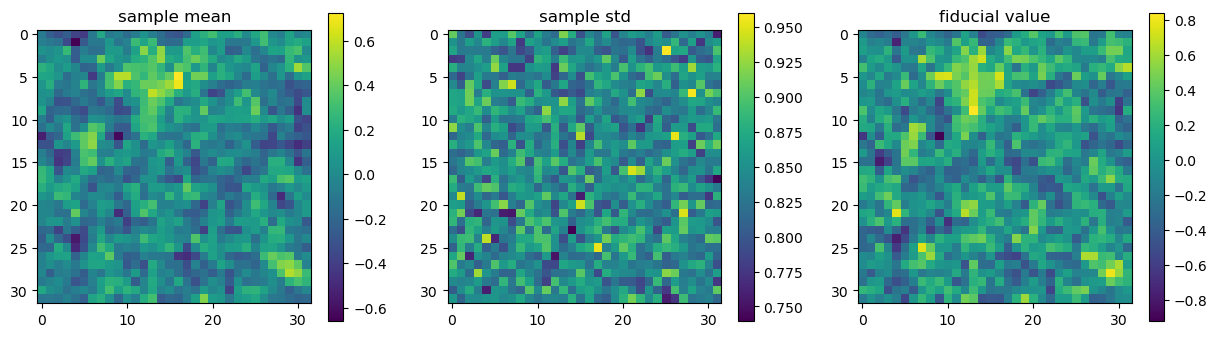

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(post_samples['init_mesh'].mean(0).mean(0))
plt.title("sample mean"), plt.colorbar()
plt.subplot(132)
plt.imshow(post_samples['init_mesh'].std(0).mean(0))
plt.title("sample std"), plt.colorbar()
plt.subplot(133)
plt.imshow(fiducial_trace['init_mesh']['value'].mean(0))
plt.title("fiducial value"), plt.colorbar()
plt.show();